## Environment Setup

In [ ]:
! apt-get install default-jre
! java -version
! pip install h2o

Reading package lists... Done
Building dependency tree       
Reading state information... Done
default-jre is already the newest version (2:1.11-68ubuntu1~18.04.1).
default-jre set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
     |████████████████████████████████| 164.6MB 67kB/s 
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=f080e3e07f93b636a2dd3d93badbe6fc02ab4d0af940bccf1a0efa7a315ed132
  Stored in directory: /root/.cache/pip/wheels/42/bd/ea/218fd15724eddf6fa7fc8fab802b6fa592e623d87199679721
Successfully built h2o


In [ ]:
import h2o
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator

file_path = "/content/drive/My Drive/Colab Notebooks/IPRAD/creditcard.csv"

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Initialise H2O

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9.1" 2020-11-04; OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphlwz2kxt
  JVM stdout: /tmp/tmphlwz2kxt/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphlwz2kxt/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_h6mxvc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


## Data Preparation

We will be using the credit card data set, which contains information on various properties of credit card transactions. 

The dataset includes 284,807 transactions. among them, 492 transactions are labeled as frauds. Because of this, the dataset is highly imbalanced. It contains only numerical variables. Feature ‘Time’ contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature ‘Amount’ is the transaction Amount, this feature can be used for example-dependent cost-sensitive learning. Feature ‘Class’ is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [ ]:
creditData = pd.read_csv(file_path) 
creditData.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
creditData.shape

(284807, 31)

In [ ]:
creditData.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking for null values in the dataset




In [ ]:
creditData.isnull().values.any()

False

In order to proceed we need to convert the pandas data frame to H2O data frame


Parse progress: |█████████████████████████████████████████████████████████| 100%


Text(0, 0.5, 'Frequency')

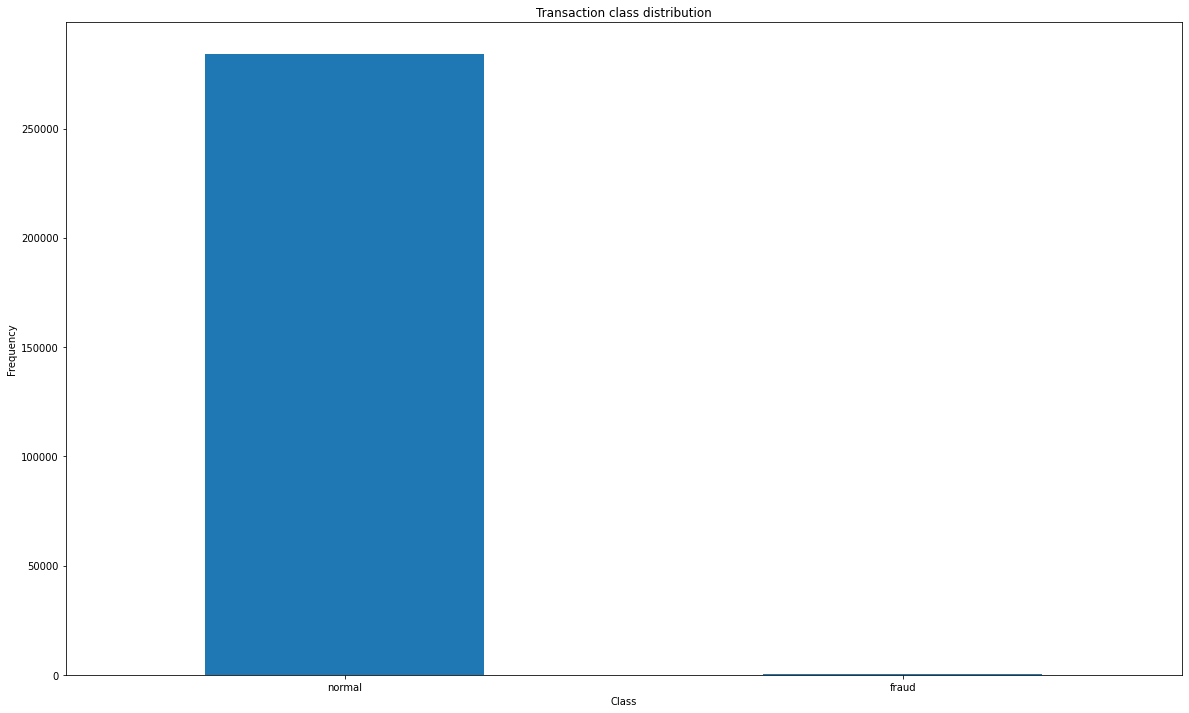

In [ ]:
# Turns python pandas frame into an H2OFrame
creditData_h2o  = h2o.H2OFrame(creditData)
# Let’s plot the Transaction class against the Frequency
labels = ["normal","fraud"]
classes = pd.value_counts(creditData["Class"], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

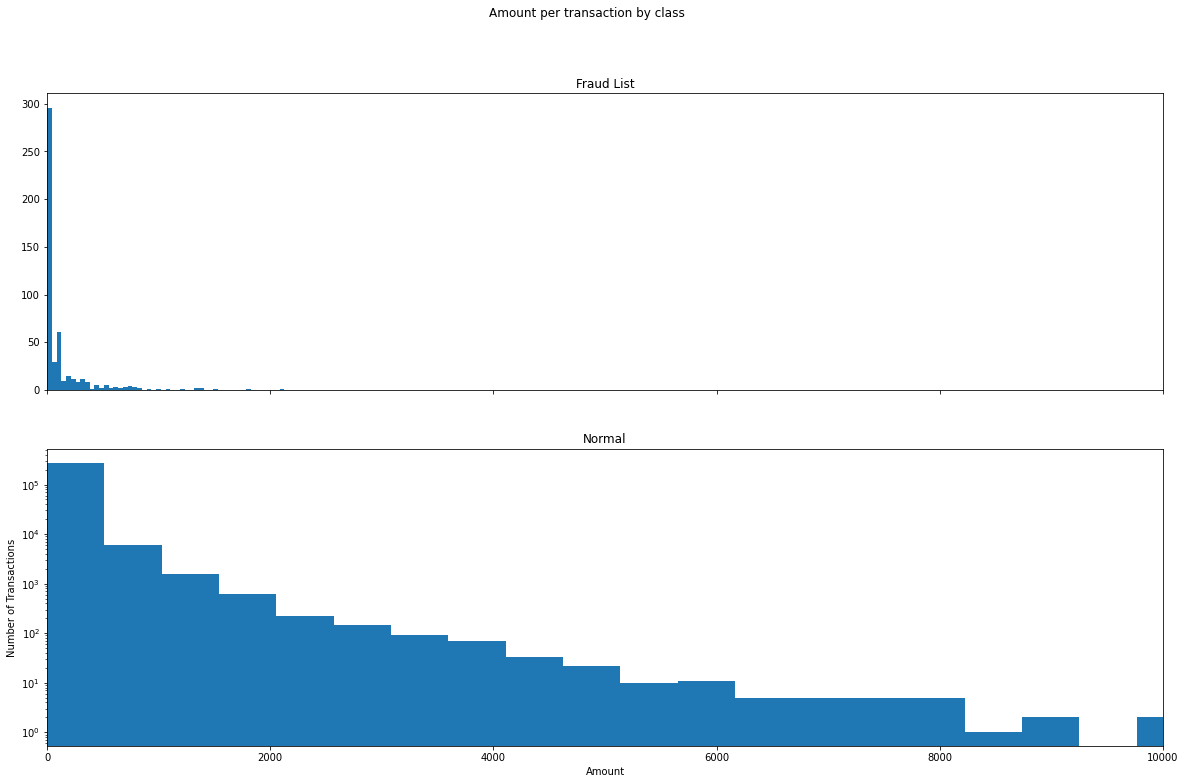

In [ ]:
fraud = creditData[creditData.Class == 1]
normal = creditData[creditData.Class == 0]
# Amount vs Class
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Amount per transaction by class')
ax1.hist(fraud.Amount, bins = 50)
ax1.set_title('Fraud List')
ax2.hist(normal.Amount, bins = 50)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0, 10000))
plt.yscale('log')
plt.show()

**Preparing Data**

The Time variable is not giving an impact on the model prediction. This can figure out from data visualization. Before moving on to the training part, we need to figure out which variables are important and which are not. So we can drop the unwanted variables.

In [ ]:
features= creditData_h2o.drop(['Time'], axis=1)

Split the data frame as training set and testing set keeping 80% for the training set and rest to the testing set.

In [ ]:
train, test = features.split_frame([0.8])
print(train.shape)
print(test.shape)

(227627, 30)
(57180, 30)


Our dataset has a lot of non-fraud transactions. Because of this for the model training, we only send non-fraud transactions. So that the model will learn the pattern of normal transactions.


In [ ]:
# converting to pandas dataframe
train_df = train.as_data_frame()
test_df = test.as_data_frame()
train_df = train_df[train_df['Class'] == 0]
# drop the Class variable
train_df = train_df.drop(['Class'], axis=1)
Y_test_df = test_df['Class'] # true labels of the testing set
test_df = test_df.drop(['Class'], axis=1)
train_df.shape

(227226, 29)

## Create and Train Model

In [ ]:
train_h2o = h2o.H2OFrame(train_df) # converting to h2o frame
test_h2o = h2o.H2OFrame(test_df)
x = train_h2o.columns

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


When building the model, 4 fully connected hidden layers were chosen with, [14,7,7,14] number of nodes for each layer. First two for the encoder and last two for the decoder.

In [ ]:
anomaly_model = H2ODeepLearningEstimator(activation = "Tanh",
                               hidden = [14,7,7,14],
                               epochs = 100,
                               standardize = True,
                                stopping_metric = 'MSE', 
                                loss = 'automatic',
                                train_samples_per_iteration = 32,
                                shuffle_training_data = True,     
                               autoencoder = True,
                               l1 = 10e-5)
anomaly_model.train(x=x, training_frame = train_h2o)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [ ]:
anomaly_model.model_performance()


ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.0008076330828329332
RMSE: 0.028418886023785894


## Evaluate Model

Variable Importance : In H2O there is a special way of analyzing which variables are giving higher impact on the model.

In [ ]:
anomaly_model._model_json['output']['variable_importances'].as_data_frame()

,variable,relative_importance,scaled_importance,percentage
0,V26,1.000000,1.000000,0.143046
1,V9,0.994113,0.994113,0.142203
2,V11,0.989973,0.989973,0.141611
3,V15,0.987816,0.987816,0.141303
4,V18,0.985930,0.985930,0.141033
5,V24,0.985815,0.985815,0.141016
6,V13,0.982526,0.982526,0.140546
7,V19,0.015258,0.015258,0.002183
8,V4,0.007015,0.007015,0.001004
9,V22,0.005965,0.005965,0.000853


**Visualization**

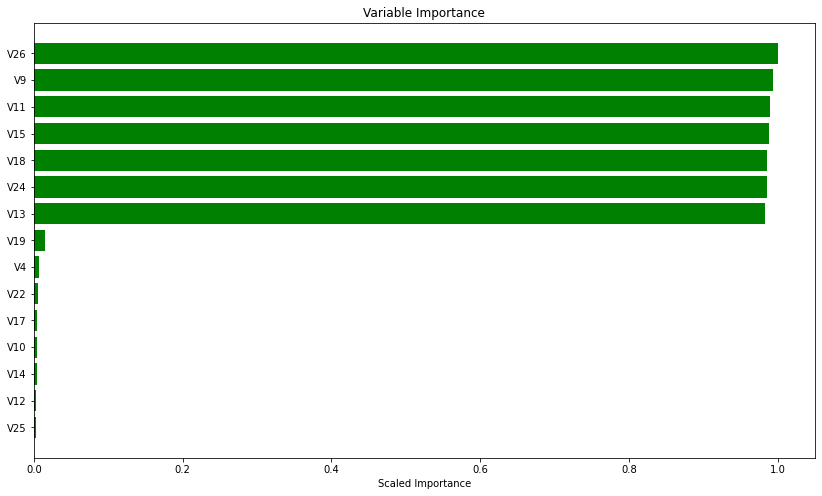

In [ ]:
# plotting the variable importance
rcParams['figure.figsize'] = 14, 8
#plt.rcdefaults()
fig, ax = plt.subplots()

variables = anomaly_model._model_json['output']['variable_importances']['variable']
var = variables[0:15]
y_pos = np.arange(len(var))

scaled_importance = anomaly_model._model_json['output']['variable_importances']['scaled_importance']
sc = scaled_importance[0:15]

ax.barh(y_pos, sc, align='center', color='green', ecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(variables)
ax.invert_yaxis()
ax.set_xlabel('Scaled Importance')
ax.set_title('Variable Importance')
plt.show()

Text(0.5, 0, 'epoch')

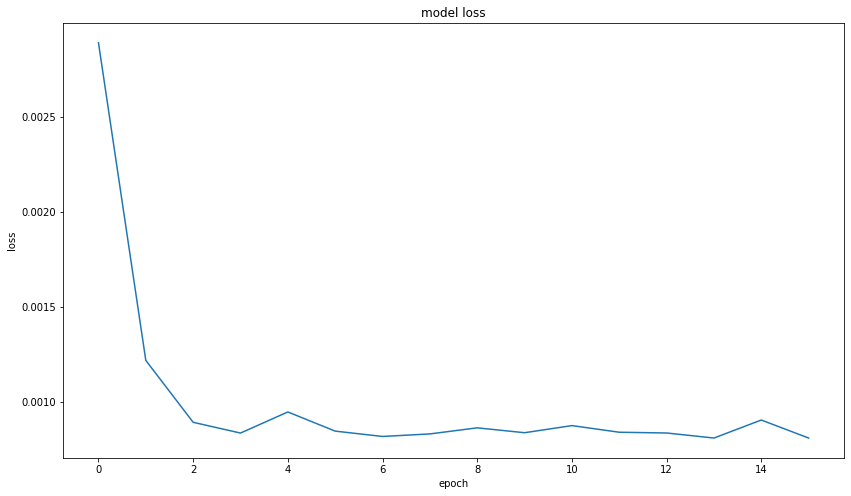

In [ ]:
# plotting the loss
scoring_history = anomaly_model.score_history()
%matplotlib inline
rcParams['figure.figsize'] = 14, 8
plt.plot(scoring_history['training_mse'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

The testing set has both normal and fraud transactions in it. The model will learn to identify the pattern of the input data. If an anomalous test point does not match the learned pattern, the autoencoder will likely have a high error rate in reconstructing this data, indicating anomalous data. So that we can identify the anomalies of the data. To calculate the error, it uses Mean Squared Error(MSE)

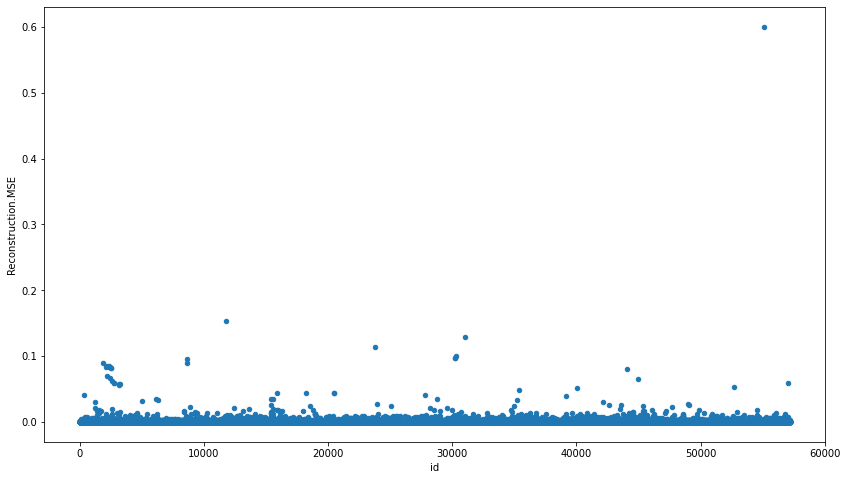

In [ ]:
test_rec_error = anomaly_model.anomaly(test_h2o) 
# anomaly is a H2O function which calculates the error for the dataset
# converting to pandas dataframe
test_rec_error_df = test_rec_error.as_data_frame()
# plotting the testing dataset against the error
test_rec_error_df['id']=test_rec_error_df.index
rcParams['figure.figsize'] = 14, 8
test_rec_error_df.plot(kind="scatter", x='id', y="Reconstruction.MSE")
plt.show()

In [ ]:
# predicting the class for the testing dataset
predictions = anomaly_model.predict(test_h2o)
error_df = pd.DataFrame({'reconstruction_error': test_rec_error_df['Reconstruction.MSE'],
                        'true_class': Y_test_df})
error_df.describe()

deeplearning prediction progress: |███████████████████████████████████████| 100%


,reconstruction_error,true_class
count,57180.000000,57180.000000
mean,0.000857,0.001591
std,0.003366,0.039862
min,0.000038,0.000000
25%,0.000326,0.000000
50%,0.000546,0.000000
75%,0.000928,0.000000
max,0.600065,1.000000


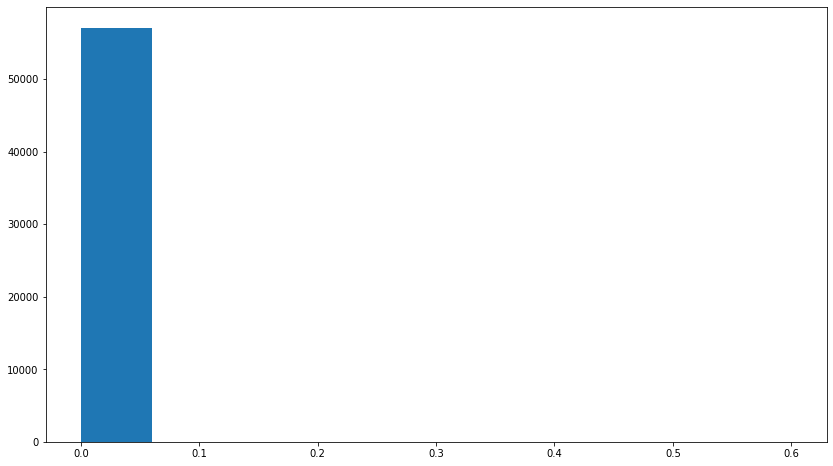

In [ ]:
# reconstruction error for the normal transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

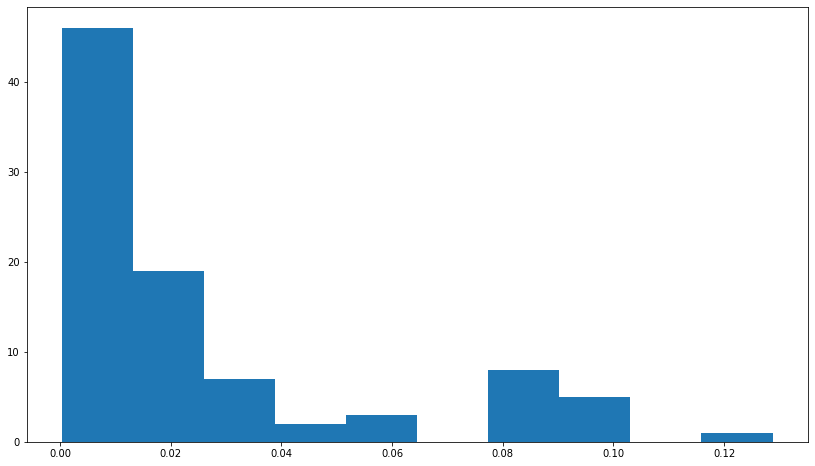

In [ ]:
# reconstruction error for the fraud transactions in the testing dataset
fig = plt.figure()
ax = fig.add_subplot(111)
rcParams['figure.figsize'] = 14, 8
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

**ROC Curve**

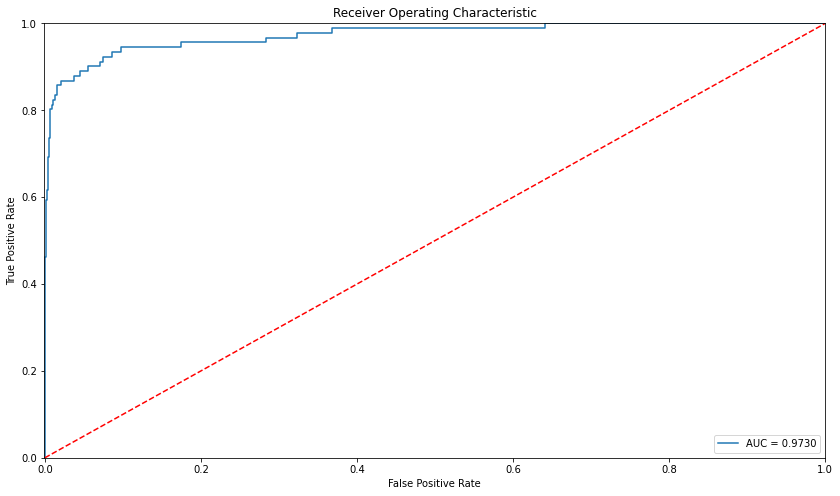

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

The accuracy is 0.9466

**Precision & Recall**

Since the data is highly imbalanced, it cannot be measured only by using accuracy. Precision vs Recall was chosen as the matrix for the classification task.

**Precision**: Measuring the relevancy of obtained results.
[ True positives / (True positives + False positives)]

**Recall**: Measuring how many relevant results are returned.
[ True positives / (True positives + False negatives)]

**True Positives** — Number of actual frauds predicted as frauds

**False Positives** — Number of non-frauds predicted as frauds

**False Negatives** — Number of frauds predicted as non-frauds.

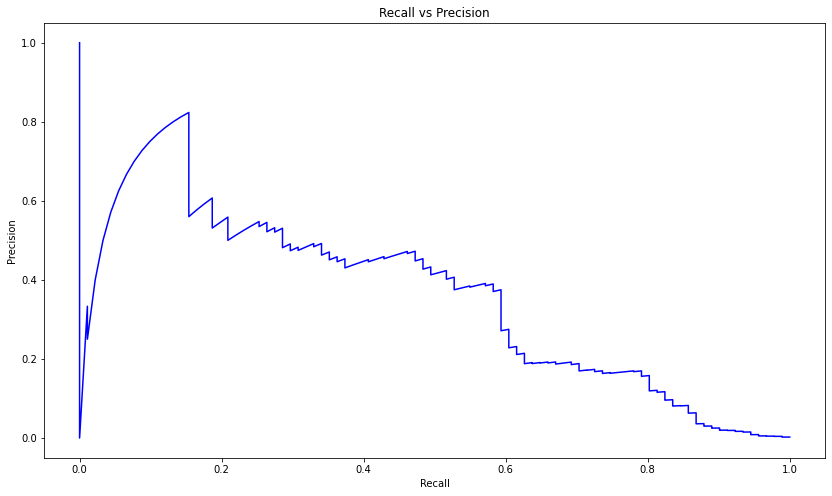

In [ ]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

We need to find a better threshold that can separate the anomalies from normal. This can be done by calculating the intersection of the Precision/Recall vs Threshold graph.

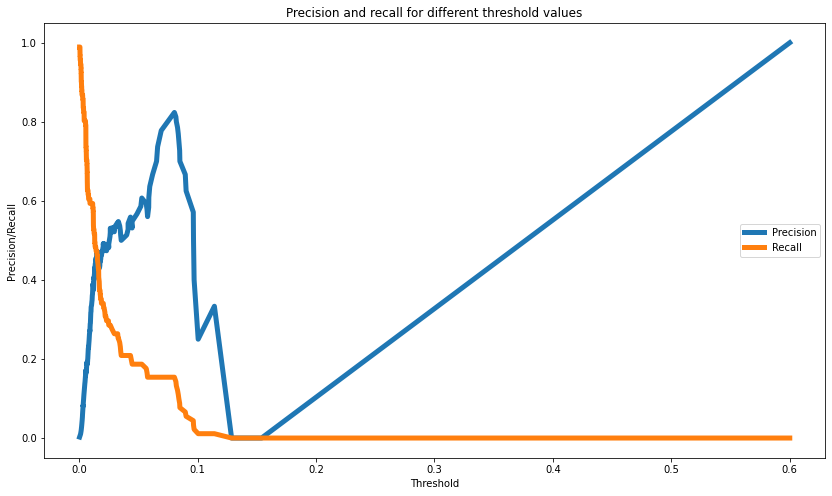

In [ ]:
plt.plot(th, precision[1:], label="Precision",linewidth=5)
plt.plot(th, recall[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

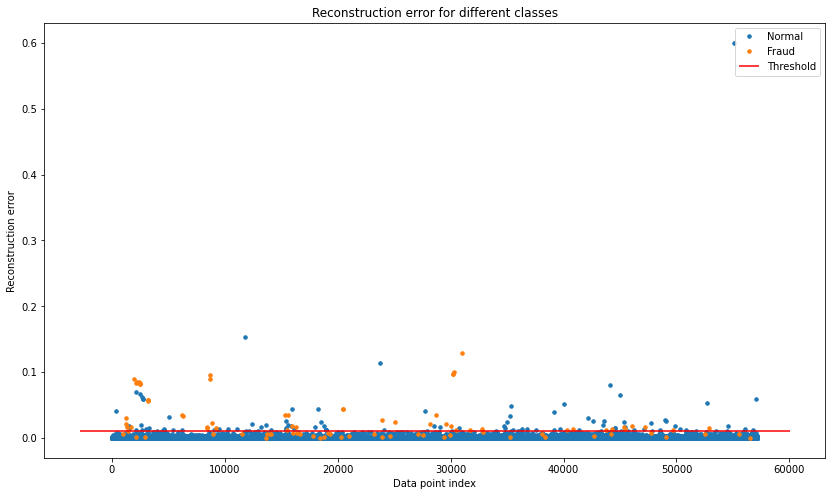

In [ ]:
# plot the testing set with the threshold
threshold = 0.01
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

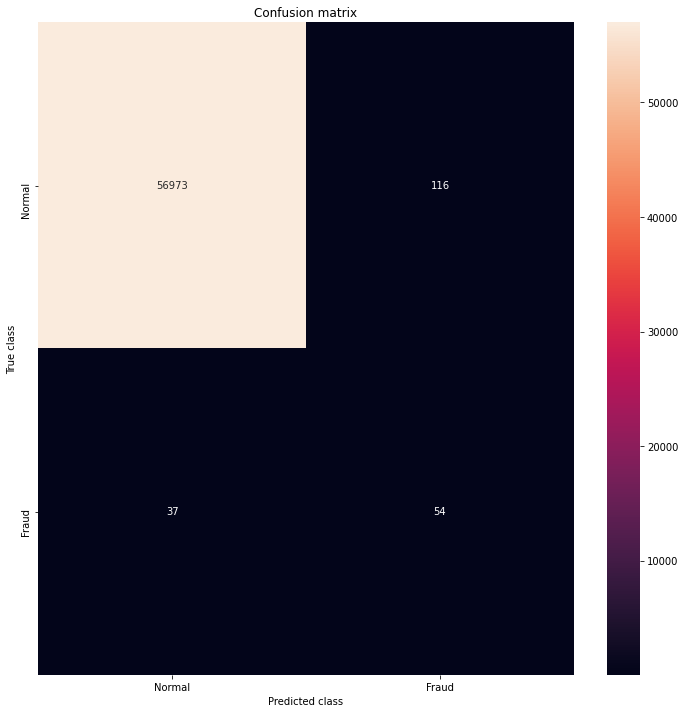

In [ ]:
import seaborn as sns
LABELS = ['Normal', 'Fraud']
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

**Classification Report**

In [ ]:
csr = classification_report(error_df.true_class, y_pred)
print(csr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     57089
           1       0.32      0.59      0.41        91

    accuracy                           1.00     57180
   macro avg       0.66      0.80      0.71     57180
weighted avg       1.00      1.00      1.00     57180

